### 1. Подключим Google диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Установим библиотеку с реализованными segmentation моделями, лоссами и необходимыми метриками

In [ ]:
!pip install -q -U git+https://github.com/qubvel/segmentation_models.pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


### 3. Импортируем все необходимые модули, библиотеки, функции и классы

In [ ]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import re
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import TverskyLoss
from torchsummary import summary
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm

### 4. Извлечем имена файлов с картинками и картами сегментации

In [ ]:
name_regex = re.compile(r'.+(?=.gz)') # регулярка для захвата имени файла
path = 'drive/MyDrive/CovidSegmentation' # путь к папке с проектом
data_path = os.path.join(path, 'data') # путь к папке с данными
path_images = os.path.join(data_path, 'images') # путь к папке с картинками
path_labels = os.path.join(data_path, 'labels') # путь к папке с картами сегментации
with open(os.path.join(path, 'training_data.json'), 'r') as f:
    dict_training = json.load(f)

images_paths = []
labels_paths = []
for entry in tqdm(dict_training):
    image_name = name_regex.findall(entry['image'])[0]
    label_name = name_regex.findall(entry['label'])[0]
    images_paths.append(os.path.join(path_images, image_name))
    labels_paths.append(os.path.join(path_labels, label_name))

  0%|          | 0/40 [00:00<?, ?it/s]

### 5. Создадим Dataset

In [ ]:
class CovidTrainDataset(Dataset):
  def __init__(self, images_paths, labels_paths):
    super().__init__()
    self.images_paths = images_paths # пути к картинкам
    self.labels_paths = labels_paths # пути к картам сегментации
    self.indexer = dict() # индексер для сохранения информации о картиках и слайсах

    i = 0
    for index, image_path in enumerate(self.images_paths):
      image = nib.load(image_path)
      image = torch.tensor(image.get_fdata()).swapaxes(0, 2).swapaxes(1, 2)
      for idx in range(image.shape[0]): # перебираем слайсы
        self.indexer[i] = {'image_index': index, 'channel_index': idx} # сохраняем информацию о картинке и слайсе
        i += 1
      del image
  
  def __len__(self):
        return len(self.indexer)
  
  def __getitem__(self, idx):
    index, channel_index = self.indexer[idx].values() # извлекаем данные о картинке и слайсе из индексера

    transform = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5), # используем трансформацию поворота с p=0.5
        transforms.RandomVerticalFlip(p=0.5)
    ])

    # извлекаем слайс картинки и трансформируем его
    image = nib.load(self.images_paths[index])
    image = transform(torch.tensor(image.get_fdata(), dtype=torch.float)).swapaxes(0, 2).swapaxes(1, 2)[channel_index, :, :].reshape(1, 512, 512)

    # извлекаем слайс карты сегментации и трансформируем его
    label = nib.load(self.labels_paths[index])
    label = transform(torch.tensor(label.get_fdata(), dtype=torch.uint8)).swapaxes(0, 2).swapaxes(1, 2)[channel_index, :, :].reshape(1, 512, 512)

    return image, label
  
  def get_from_indexer(self, image_index, slice_index):
    # находим информацию о картинке и слайсе в индексере
    for index, item in self.indexer.items():
      img_index, slc_index = item['image_index'], item['channel_index']
      if img_index == image_index and slc_index == slice_index:
        return self.__getitem__(index)

In [ ]:
dataset = CovidTrainDataset(images_paths, labels_paths)

### 6. Визуализируем исходные данные

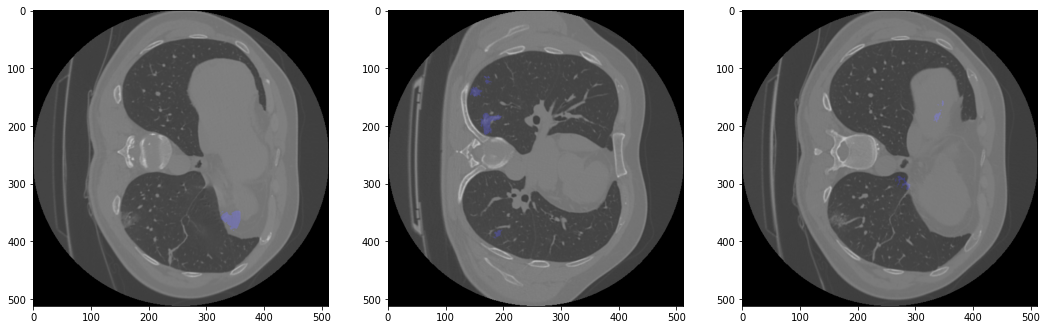

In [ ]:
#Visualize some of the slices
def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 7
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
  image, mask = dataset.get_from_indexer(patient_num, idx)
  image = image.reshape(512, 512).numpy()
  mask = mask.reshape(512, 512).numpy()
  slices.append(blend(image, mask))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

### 7. Разобъем исходный датасет на train и eval части, создадим loader-ы

In [ ]:
BATCH_SIZE = 16
TRAIN_SIZE = 0.9

train_size = int(len(dataset) * TRAIN_SIZE)
eval_size = len(dataset) - train_size

train_subset, eval_subset = random_split(dataset, [train_size, eval_size])

assert len(train_subset) + len(eval_subset) == len(dataset), 'Ошибка разбиения: несовпадение размеров исходных данных и сплитов'

In [ ]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_subset, batch_size=BATCH_SIZE, shuffle=True)

### 8. Определим функцию для подсчета метрик

In [ ]:
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)
def calculate_metrics(outputs, targets):
  dice_coefficient = 1 - dice_loss(outputs, targets).item()
  tp, fp, fn, tn = smp.metrics.get_stats(outputs, targets, mode='binary', threshold=0.5)
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro-imagewise')
  f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction='micro-imagewise')
  accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro-imagewise')
  precision = smp.metrics.precision(tp, fp, fn, tn, reduction='micro-imagewise')
  recall = smp.metrics.recall(tp, fp, fn, tn, reduction='micro-imagewise')
  metrics_dict = {'f1_score': f1_score, 
                  'precision': precision,
                  'recall': recall,
                  'IoU': iou_score,
                  'accuracy': accuracy,
                  'dice': dice_coefficient}
  return metrics_dict

### 9. Определим функцию для отображения состояния

In [ ]:
def print_status(epoch, train_loss, eval_loss, eval_metrics, grad_norm):
  print(f'epoch: {epoch}')
  print('train loss: %.4f' % (train_loss))
  print('eval loss: %.4f' % (eval_loss))
  for metric, metric_value in eval_metrics.items():
    print(f'{metric}: %.4f' % (metric_value))
  print('grad norm : %.4f' % (grad_norm))

### 10. Определим модель и параметры для обучения

In [ ]:
epochs = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name='resnet18', in_channels=1, activation='sigmoid').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = TverskyLoss(mode='binary', alpha=0.5, from_logits=False)

In [ ]:
summary(model, (1, 512, 512)) # посмотрим, из чего вообще состоит модель и сколько у нее параметров

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

### 11. Обучим модель (после каждой эпохи смотрим значения метрик на eval части)

In [ ]:
train_loss_history = []
eval_loss_histrory = []

for epoch in range(1, epochs + 1):
  train_loss = 0
  grad_norm = 0
  for image, labels in tqdm(train_loader):
    image = image.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(image)
    loss = criterion(outputs, labels)
    train_loss += loss.item()
    train_loss_history.append(loss.item())
    loss.backward()

    grad_norm += clip_grad_norm_(model.parameters(), 1000)
    optimizer.step()

  scheduler.step(loss)

  eval_loss = 0
  eval_loss_history = []
  eval_metrics = {'f1_score': 0, 
                  'precision': 0,
                  'recall': 0,
                  'IoU': 0,
                  'accuracy': 0,
                  'dice': 0}

  for image, labels in tqdm(eval_loader):
    with torch.no_grad():
      image = image.to(device)
      labels = labels.to(device)

      outputs = model(image)
      loss = criterion(outputs, labels)
      eval_loss += loss.item()
      eval_loss_history.append(loss.item())
      
      for metric, metric_value in calculate_metrics(outputs, labels).items():
        eval_metrics[metric] += metric_value
  train_loss /= len(train_loader)
  grad_norm /= len(train_loader)
  eval_loss /= len(eval_loader)
  for metric in eval_metrics.keys():
    eval_metrics[metric] /= len(eval_loader)
  print_status(epoch, train_loss, eval_loss, eval_metrics, grad_norm)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 1
train loss: 0.9874
eval loss: 0.9789
f1_score: 0.3482
precision: 0.3681
recall: 0.8053
IoU: 0.3397
accuracy: 0.9267
dice: 0.0211
grad norm : 0.0402


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 2
train loss: 0.9628
eval loss: 0.9326
f1_score: 0.4294
precision: 0.4930
recall: 0.7334
IoU: 0.4172
accuracy: 0.9884
dice: 0.0674
grad norm : 0.2639


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 3
train loss: 0.8993
eval loss: 0.8451
f1_score: 0.5371
precision: 0.6530
recall: 0.6735
IoU: 0.5162
accuracy: 0.9951
dice: 0.1549
grad norm : 0.9001


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 4
train loss: 0.7979
eval loss: 0.7609
f1_score: 0.5428
precision: 0.7611
recall: 0.6544
IoU: 0.5245
accuracy: 0.9972
dice: 0.2391
grad norm : 1.0986


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 5
train loss: 0.8034
eval loss: 0.7567
f1_score: 0.4900
precision: 0.6017
recall: 0.6804
IoU: 0.4667
accuracy: 0.9968
dice: 0.2433
grad norm : 0.9019


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 6
train loss: 0.7603
eval loss: 0.7444
f1_score: 0.5893
precision: 0.7608
recall: 0.6651
IoU: 0.5686
accuracy: 0.9978
dice: 0.2556
grad norm : 1.0307


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 7
train loss: 0.7417
eval loss: 0.7189
f1_score: 0.5910
precision: 0.7022
recall: 0.6835
IoU: 0.5665
accuracy: 0.9970
dice: 0.2811
grad norm : 0.8886


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 8
train loss: 0.7402
eval loss: 0.6689
f1_score: 0.5730
precision: 0.6588
recall: 0.7342
IoU: 0.5482
accuracy: 0.9969
dice: 0.3311
grad norm : 1.0620


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 9
train loss: 0.7409
eval loss: 0.7739
f1_score: 0.5786
precision: 0.7003
recall: 0.6729
IoU: 0.5566
accuracy: 0.9969
dice: 0.2261
grad norm : 0.9304


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 10
train loss: 0.7302
eval loss: 0.7546
f1_score: 0.5119
precision: 0.6431
recall: 0.6497
IoU: 0.4876
accuracy: 0.9966
dice: 0.2454
grad norm : 0.8265


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 11
train loss: 0.7482
eval loss: 0.6414
f1_score: 0.5915
precision: 0.7130
recall: 0.6625
IoU: 0.5678
accuracy: 0.9973
dice: 0.3586
grad norm : 0.7433


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 12
train loss: 0.7019
eval loss: 0.7927
f1_score: 0.5767
precision: 0.7128
recall: 0.6768
IoU: 0.5572
accuracy: 0.9971
dice: 0.2073
grad norm : 0.8524


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 13
train loss: 0.7170
eval loss: 0.7410
f1_score: 0.5779
precision: 0.6903
recall: 0.6946
IoU: 0.5575
accuracy: 0.9972
dice: 0.2590
grad norm : 0.8517


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 14
train loss: 0.7038
eval loss: 0.7420
f1_score: 0.5690
precision: 0.6800
recall: 0.6893
IoU: 0.5474
accuracy: 0.9968
dice: 0.2580
grad norm : 0.8145


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

epoch: 15
train loss: 0.7293
eval loss: 0.8081
f1_score: 0.5808
precision: 0.6523
recall: 0.6914
IoU: 0.5675
accuracy: 0.9967
dice: 0.1919
grad norm : 0.8306


### 12. Посмотрим на лосс (на train и eval)

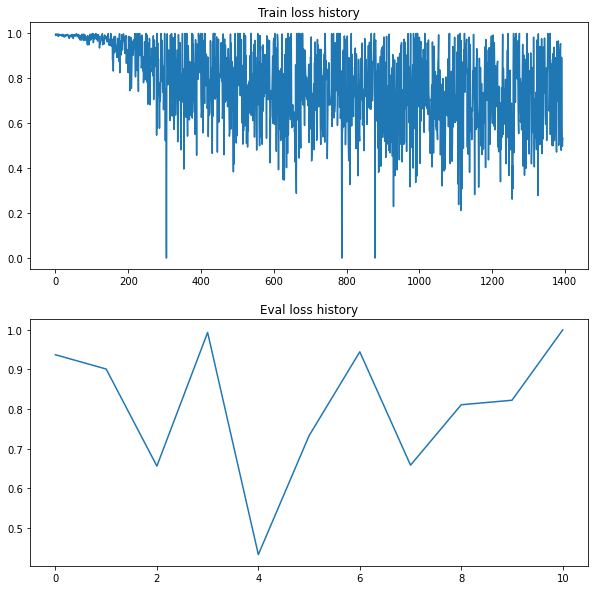

In [ ]:
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(2, 1, 1)
ax.set_title('Train loss history')
ax.plot(train_loss_history)

ax = figure.add_subplot(2, 1, 2)
ax.set_title('Eval loss history')
ax.plot(eval_loss_history)

### 13. Сохраним модель

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CovidSegmentation/model.pth')

### 14. Загрузим модель для финального предсказания

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name='resnet18', in_channels=1, activation='sigmoid')
model.load_state_dict(torch.load('/content/drive/MyDrive/CovidSegmentation/model.pth'))
model.to(device)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### 15. Сделаем предсказание и сгенерируем сабмит

In [ ]:
with open(os.path.join(path, 'testing_data.json'), 'r') as f:
    dict_testing = json.load(f)

images_testing = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, name_regex.findall(entry['image'])[0]))
    images_testing.append(image.get_fdata())

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
threshold = 0.5
images_cnt = len(images_testing)
labels_predicted = []
for image_index in range(images_cnt):
  slices_cnt = images_testing[image_index].shape[-1]
  slices = []
  for slice_index in range(slices_cnt):
    input = images_testing[image_index][:, :, slice_index] # кормим модели слайсы картинок по 1 штуке
    input = torch.tensor(input, dtype=torch.float).to(device).reshape(-1, 1, 512, 512)
    output = model(input).cpu().detach().numpy()[0]
    output = output.swapaxes(0, 1).swapaxes(1, 2)
    output[output > threshold] = 1
    output[output <= threshold] = 0
    slices.append(output)
  labels_predicted.append(np.concatenate(slices, axis=2))

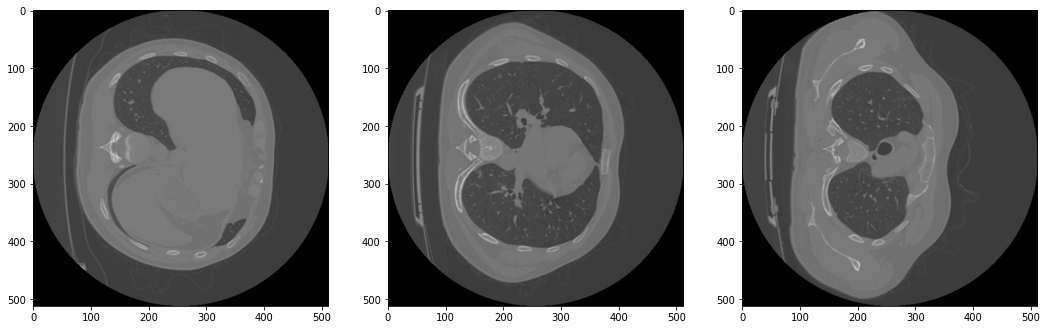

In [ ]:
# Visualize some of the predictions

patient_num = 5
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testing[patient_num][..., idx],
        labels_predicted[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("/content/drive/MyDrive/CovidSegmentation/submission.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for test_item, patient in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{test_item['image'][:-7]}",
                " ".join(rle_encoding(patient))
            ])

0it [00:00, ?it/s]